In [1]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, optimization_visualization_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
importlib.reload(optimization_visualization_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, contact_optimization, get_double_side_view, show_selected_joints, get_max_distance_to_target_surface, get_average_distance_to_target_surface, get_normal_deviation)
from optimization_visualization_helper import (compute_visualization_data_from_raw_data, get_objective_components_stage1, get_objective_components_stage2, set_figure_label_and_limit, Visualization_Setting, plot_objective)

import vis.fields
import matplotlib.cm as cm
import time

In [2]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [3]:
rod_length = 0.09982061776030171
width = rod_length / 20 * 5
thickness = width / 5 * 0.35
print(width, thickness)
io = InputOrganizer('bunny_head_small_triaxial_1', thickness, width, weaving_dir)

0.024955154440075428 0.0017468608108052797


In [4]:
import py_newton_optimizer
OPTS = py_newton_optimizer.NewtonOptimizerOptions()
OPTS.gradTol = 1e-8
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False
rw = 1
sw = 10
drw = 0.1
dsw = 0.1

### Initialization

In [5]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.weaving)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

#### Compute the joint normals from the target surface

In [6]:
input_joint_normals = np.reshape(curved_linkage.get_closest_point_normal(curved_linkage.jointPositions()), (curved_linkage.numJoints(), 3))

#### For the normals around the ears, it is better to use the best fit plane normal. So only swap out the troubling vertex 35

In [7]:
current_joint_normals = [curved_linkage.joint(i).normal for i in range(curved_linkage.numJoints())]
current_joint_normals[35] = input_joint_normals[35]

In [8]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=True, interleaving_type=InterleavingType.triaxialWeave, input_joint_normals = current_joint_normals)
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewer(curved_linkage)
# set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='#999999', position=(0.0, 0.0, 5.0), quaternion=(…

In [9]:
curved_linkage.setExtendedDoFsPSRL(np.load('../results/bunny_head_small_triaxial_1/bunny_head_small_triaxial_1_dof.npy'))

In [10]:
topColor =[79/255., 158/255., 246/255.]
bottomColor =[0.5, 0.5, 0.5]
heights = curved_linkage.visualizationGeometryHeightColors()
colors = np.take(np.array([bottomColor, topColor]), heights < heights.mean(), axis=0)

In [11]:
curved_linkage_view.update(scalarField=colors)

In [12]:
curved_linkage_view.setCameraParams(((4.139347366530763, -3.927678946178955, 0.7924706632167623),
 (-0.038125872037145875, 0.15887387844372028, 0.9865624707182293),
 (0.0, 0.0, 0.0)))

In [13]:
curved_linkage.attraction_weight = 1e-7

In [14]:
# iterateData = stage_1_optimization(curved_linkage, 0.1, 0.1, curved_linkage_view)

In [15]:
# curved_linkage.setMaterial(elastic_rods.RodMaterial('rectangle', 2000, 0.3, [thickness, width], stiffAxis=elastic_rods.StiffAxis.D1))

In [16]:
def eqm_callback(prob, i):
    curved_linkage_view.update(scalarField=colors)

In [17]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)

0	0.00362397	0.995834	0.995834	1	1
1	0.00051025	0.130272	0.130272	1	1
2	0.000287047	0.0333202	0.0333202	1	1
3	0.000185069	0.0143503	0.0143503	1	1
4	0.000122162	0.00708733	0.00708733	1	1
5	8.22793e-05	0.00372542	0.00372542	1	1
6	5.79478e-05	0.00231375	0.00231375	1	1
7	4.44073e-05	0.00170376	0.00170376	1	1
8	3.78247e-05	0.00131208	0.00131208	1	1
9	3.49548e-05	0.00109482	0.00109482	1	1
10	3.38037e-05	0.00075974	0.00075974	1	1
11	3.33946e-05	0.000414555	0.000414555	1	1
12	3.32639e-05	0.000165779	0.000165779	1	1
13	3.32256e-05	5.72584e-05	5.72584e-05	1	1
14	3.32151e-05	2.04583e-05	2.04583e-05	1	1
15	3.32121e-05	8.70601e-06	8.70601e-06	1	1
16	3.32113e-05	3.84519e-06	3.84519e-06	0.5	0
17	3.32111e-05	2.77098e-05	2.77098e-05	1	0
18	3.3211e-05	3.78063e-06	3.78063e-06	0.015625	0
19	3.3211e-05	6.63871e-06	6.63871e-06	0.5	0
20	3.3211e-05	1.05627e-05	1.05627e-05	1	0
21	3.32109e-05	1.20811e-05	1.20811e-05	1	0
22	3.32109e-05	2.16737e-05	2.16737e-05	1	0
23	3.32108e-05	1.46404e-05	1.46404e-05	0.5	0
24	3

In [18]:
# import vis
# from matplotlib import cm

# stress = curved_linkage.maxBendingStresses()
# new_stress = np.ones_like(stress) * np.max(stress)
# new_stress[0] = stress[0]
# new_stress[34] = stress[34]


# #stress = curved_linkage.twistingStresses()
# rangeMin = np.stack(stress).min()
# rangeMax = np.stack(stress).max()
# sf = vis.fields.ScalarField(curved_linkage, new_stress, colormap=cm.magma, vmin=rangeMin, vmax=rangeMax)

# curved_linkage_view.showScalarField(sf)

In [ ]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw)

In [ ]:
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -3, 3)

### Validation

In [ ]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = [])
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

In [ ]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

In [ ]:
# double_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(double_view)
# double_view.show()

In [ ]:
# double_view.viewOptions[double_view.ViewType.SURFACE].color

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# get_average_distance_to_target_surface(curved_linkage)/io.RIBBON_CS[1]

In [ ]:
# distance_to_surface = np.array(curved_linkage.get_squared_distance_to_target_surface((curved_linkage.visualizationGeometry()[0]).flatten()))


In [ ]:
# distance_to_surface = np.sqrt(distance_to_surface)

In [ ]:
# plt.plot(np.sort(distance_to_surface))

In [ ]:
# set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

In [ ]:
# save_path = os.getcwd()
# write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False, width = max(io.RIBBON_CS))
# os.chdir(save_path)

## Contact Optimization

In [25]:
def get_opposite_joint_type(curr_type):
    if curr_type == curved_linkage.joint(0).Type.A_OVER_B:
        return curved_linkage.joint(0).Type.B_OVER_A
    return curved_linkage.joint(0).Type.A_OVER_B
import structural_analysis

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


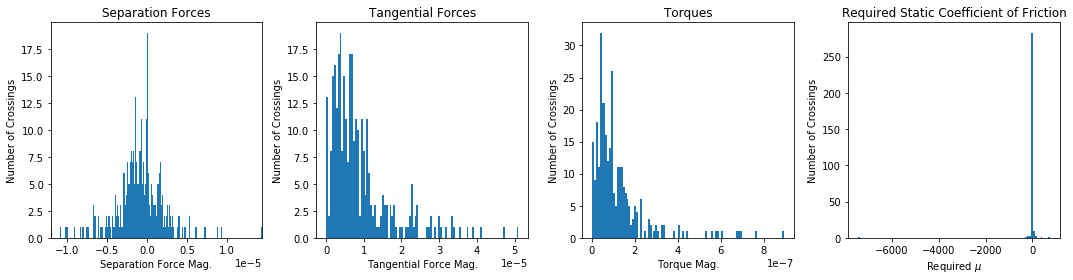

In [23]:
structure_view = get_structure_analysis_view(curved_linkage)
structure_view.show()

In [26]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [284   3   2 285 312  37  38  19 252  35 255 254 289 270 292 290 299  26
 269  28 302 267 303 304 275 276 261  23 306  22 298 308 124 220 244 180
  90  93 174 171  96 169 168  97  98 164 162 161 160 158 102 103 105 152
 147 146 113 140 138 137 136 130 182  87  86 185 243 242  49 237  50  53
  57 222 221 219 218 217  64 246  66  70 206 205  73 203 202  77  78 196
 194  82 190 186 211 314]
0	0.000672825	0.19106	0.19106	1	1
1	0.000220702	0.299384	0.299384	1	1
2	0.000152793	0.0196724	0.0196724	1	1
3	0.000138293	0.0108652	0.0108652	1	1
4	0.00012147	0.00836777	0.00836777	1	0
5	5.99636e-05	0.0420949	0.0420949	1	1
6	4.50026e-05	0.00322977	0.00322977	1	0
7	3.878e-05	0.0152137	0.0152137	1	1
8	3.60814e-05	0.00196074	0.00196074	1	1
9	3.57216e-05	0.00139331	0.00139331	1	1
10	3.55316e-05	0.00026181	0.00026181	1	0
11	3.53438e-05	0.00360627	0.00360627	0.5	1
12	3.51119e-05	0.0036063	0.0036063	1	1
13	3.49769e-05	0.00373914	0.00373914	1	1
14	3.49277e-05	0.00173201	0.00173201	0.5	0
15	

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


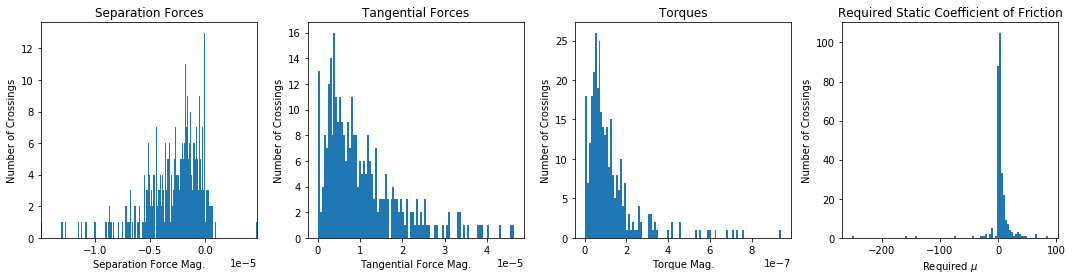

In [27]:
second_structure_view = get_structure_analysis_view(curved_linkage)
second_structure_view.show()

In [28]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [198 199 148 145 304  88 127 179  32 123  95 214  62 283 111 208  51 120]
0	0.000135233	0.0672558	0.0672558	0.25	1
1	0.000104639	0.0737735	0.0737735	1	1
2	6.42733e-05	0.00949996	0.00949996	1	1
3	5.32982e-05	0.00476671	0.00476671	1	0
4	3.95178e-05	0.0142182	0.0142182	1	1
5	3.68447e-05	0.000997811	0.000997811	1	0
6	3.5192e-05	0.00371297	0.00371297	1	1
7	3.5035e-05	0.000146592	0.000146592	1	0
8	3.49266e-05	0.000415867	0.000415867	1	0
9	3.49254e-05	0.00041994	0.00041994	1	0
10	3.49152e-05	4.8569e-05	4.8569e-05	0.5	0
11	3.49148e-05	4.70893e-05	4.70893e-05	1	0
12	3.49143e-05	2.55696e-05	2.55696e-05	0.5	0
13	3.49141e-05	4.11677e-05	4.11677e-05	1	0
14	3.49137e-05	2.08074e-05	2.08074e-05	0.25	0
15	3.49134e-05	3.07182e-05	3.07182e-05	1	0
16	3.49129e-05	4.0958e-05	4.0958e-05	1	0
17	3.49124e-05	3.38416e-05	3.38416e-05	1	0
18	3.49119e-05	5.52238e-05	5.52238e-05	1	0
19	3.49113e-05	2.54321e-05	2.54321e-05	0.5	0
20	3.49111e-05	3.45344e-05	3.45344e-05	1	0
21	3.49109e-05	2.51913e-05	

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


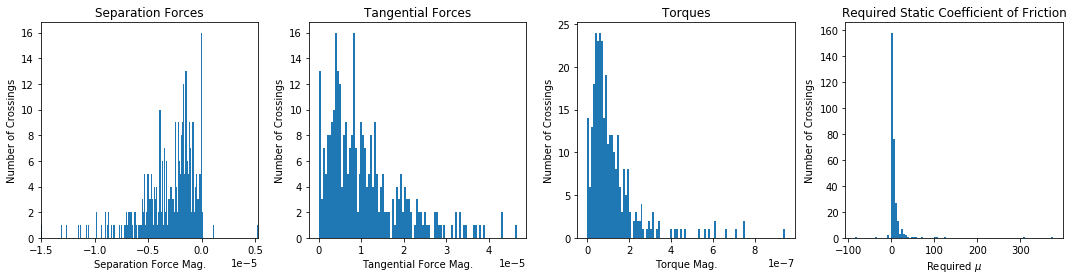

In [29]:
third_structure_view = get_structure_analysis_view(curved_linkage)
third_structure_view.show()

In [30]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [304  61  91 216]
0	5.75962e-05	0.0328308	0.0328308	1	1
1	3.95154e-05	0.0070922	0.0070922	1	1
2	3.6793e-05	0.00296587	0.00296587	1	1
3	3.58663e-05	0.000730599	0.000730599	1	1
4	3.54571e-05	0.000327789	0.000327789	1	1
5	3.52466e-05	0.000160432	0.000160432	1	1
6	3.513e-05	9.3076e-05	9.3076e-05	1	1
7	3.50629e-05	5.85221e-05	5.85221e-05	1	1
8	3.50225e-05	3.73172e-05	3.73172e-05	1	1
9	3.49966e-05	2.5153e-05	2.5153e-05	1	1
10	3.49785e-05	1.96367e-05	1.96367e-05	1	1
11	3.49657e-05	1.94874e-05	1.94874e-05	1	1
12	3.49574e-05	1.73152e-05	1.73152e-05	1	1
13	3.49527e-05	1.25331e-05	1.25331e-05	1	1
14	3.49498e-05	1.18923e-05	1.18923e-05	1	1
15	3.49475e-05	1.76361e-05	1.76361e-05	0.015625	0
16	3.4947e-05	5.11325e-05	5.11325e-05	0.25	0
17	3.49455e-05	0.000220711	0.000220711	1	0
18	3.49392e-05	6.83754e-05	6.83754e-05	0.25	0
19	3.49377e-05	0.000146146	0.000146146	1	0
20	3.49339e-05	5.01946e-05	5.01946e-05	0.5	0
21	3.49332e-05	0.000158966	0.000158966	1	0
22	3.49289e-05	4.06206e-05	4.

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


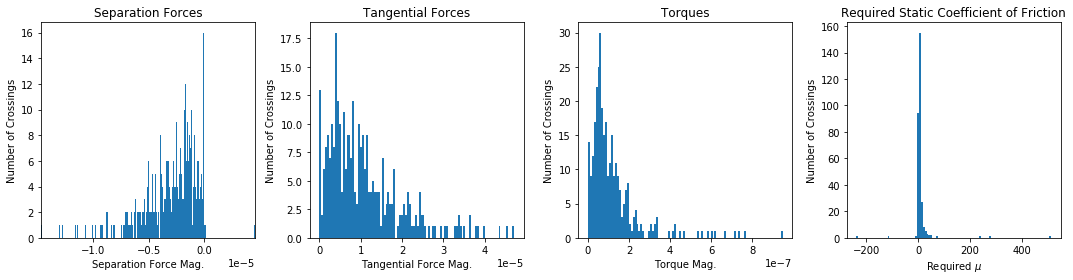

In [31]:
fourth_structure_view = get_structure_analysis_view(curved_linkage)
fourth_structure_view.show()

In [32]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [33]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-6)

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


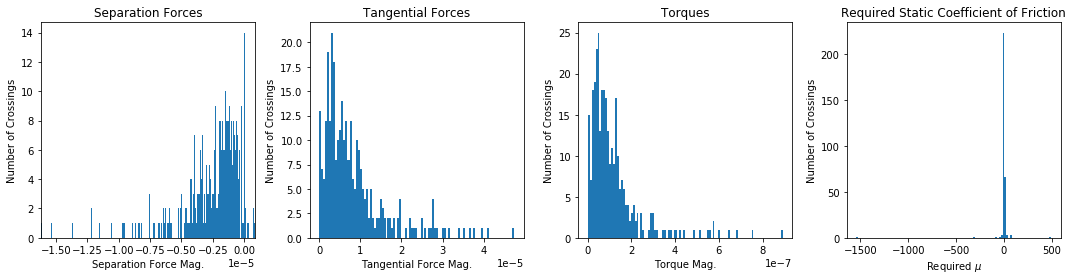

In [34]:
structure_view_4 = get_structure_analysis_view(curved_linkage)
structure_view_4.show()

In [35]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [280 175 108 304  84 295 308  74]
0	7.89644e-05	0.050438	0.050438	1	1
1	5.06604e-05	0.0678699	0.0678699	1	1
2	4.24944e-05	0.0058353	0.0058353	1	1
3	4.06622e-05	0.00199869	0.00199869	1	1
4	3.90291e-05	0.00136218	0.00136218	1	0
5	3.77781e-05	0.0114704	0.0114704	1	1
6	3.53778e-05	0.000728621	0.000728621	1	0
7	3.52242e-05	0.00394213	0.00394213	1	1
8	3.4821e-05	0.000198726	0.000198726	1	1
9	3.47628e-05	8.5291e-05	8.5291e-05	1	0
10	3.46759e-05	0.000702468	0.000702468	1	1
11	3.46533e-05	2.15832e-05	2.15832e-05	1	0
12	3.4641e-05	0.000404112	0.000404112	1	0
13	3.46344e-05	0.000110877	0.000110877	1	0
14	3.46343e-05	0.000235265	0.000235265	1	0
15	3.46319e-05	1.02913e-05	1.02913e-05	1	0
16	3.46318e-05	1.22801e-05	1.22801e-05	1	0
17	3.46318e-05	8.57063e-06	8.57063e-06	1	0
18	3.46318e-05	3.54669e-07	3.54669e-07	0.25	0
19	3.46318e-05	4.92602e-06	4.92602e-06	1	0
20	3.46318e-05	7.40955e-07	7.40955e-07	0.5	0
21	3.46318e-05	5.00295e-06	5.00295e-06	1	0
22	3.46318e-05	4.98224e-07	4.9822

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


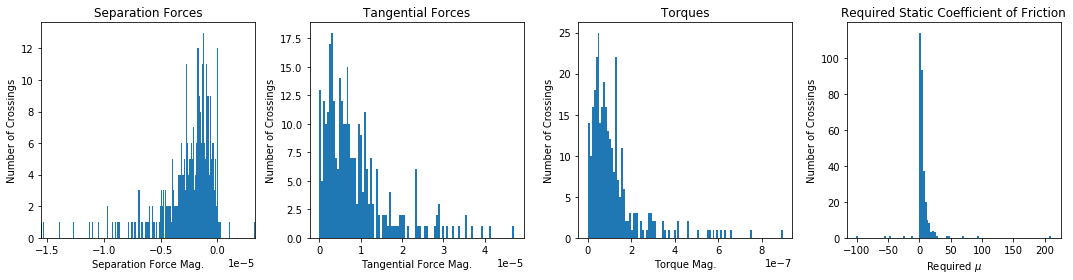

In [36]:
structure_view_5 = get_structure_analysis_view(curved_linkage)
structure_view_5.show()

In [37]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [219 304 268 250 274]
0	6.08858e-05	0.0387948	0.0387948	1	1
1	4.00457e-05	0.00850057	0.00850057	1	1
2	3.69281e-05	0.00339449	0.00339449	1	1
3	3.5823e-05	0.000768976	0.000768976	1	1
4	3.53159e-05	0.000376929	0.000376929	1	1
5	3.50495e-05	0.000191673	0.000191673	1	1
6	3.48979e-05	0.000111793	0.000111793	1	1
7	3.48082e-05	7.15607e-05	7.15607e-05	1	1
8	3.47552e-05	4.70152e-05	4.70152e-05	1	1
9	3.47238e-05	3.11004e-05	3.11004e-05	1	1
10	3.47047e-05	2.19991e-05	2.19991e-05	1	1
11	3.46932e-05	1.52022e-05	1.52022e-05	1	1
12	3.46861e-05	1.05826e-05	1.05826e-05	1	1
13	3.46815e-05	9.8345e-06	9.8345e-06	0.125	0
14	3.46783e-05	0.000156516	0.000156516	0.5	0
15	3.46709e-05	0.000164295	0.000164295	1	0
16	3.46657e-05	7.27321e-05	7.27321e-05	1	0
17	3.46652e-05	0.00016909	0.00016909	1	0
18	3.46628e-05	1.3213e-05	1.3213e-05	0.5	0
19	3.46625e-05	4.80663e-05	4.80663e-05	1	0
20	3.46621e-05	2.23415e-05	2.23415e-05	1	0
21	3.4662e-05	3.78349e-05	3.78349e-05	1	0
22	3.46618e-05	2.98712e-06	2.9

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


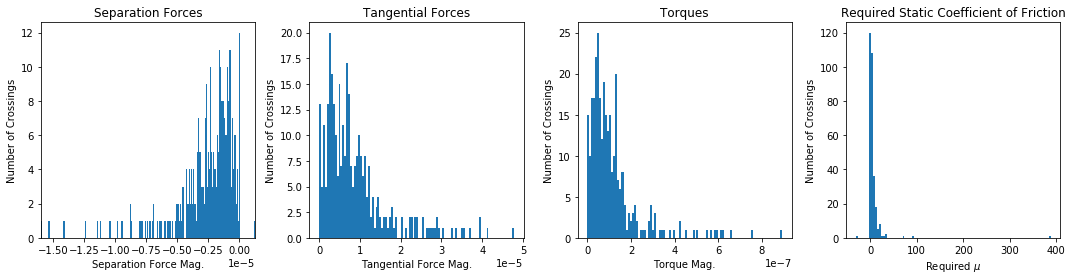

In [38]:
structure_view_6 = get_structure_analysis_view(curved_linkage)
structure_view_6.show()

In [39]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [304]
0	3.93383e-05	0.0177156	0.0177156	0.25	1
1	3.78706e-05	0.0156505	0.0156505	1	1
2	3.55334e-05	0.00737301	0.00737301	1	1
3	3.50913e-05	0.00817045	0.00817045	1	1
4	3.4875e-05	0.000317383	0.000317383	0.0625	0
5	3.4856e-05	0.000489793	0.000489793	1	0
6	3.47462e-05	0.00132205	0.00132205	1	0
7	3.46763e-05	0.000564336	0.000564336	1	0
8	3.46672e-05	0.000226155	0.000226155	0.5	0
9	3.46643e-05	0.000288557	0.000288557	1	0
10	3.46593e-05	1.70351e-05	1.70351e-05	0.5	0
11	3.4659e-05	4.97836e-05	4.97836e-05	1	0
12	3.46587e-05	1.44322e-05	1.44322e-05	1	0
13	3.46586e-05	7.54113e-06	7.54113e-06	1	0
14	3.46586e-05	3.23891e-06	3.23891e-06	1	0
15	3.46586e-05	8.13614e-06	8.13614e-06	1	0
16	3.46586e-05	1.14607e-06	1.14607e-06	0.25	0
17	3.46586e-05	3.4272e-06	3.4272e-06	1	0
18	3.46586e-05	5.20146e-06	5.20146e-06	1	0
19	3.46586e-05	2.10855e-06	2.10855e-06	0.5	0
20	3.46586e-05	3.77137e-06	3.77137e-06	1	0
21	3.46586e-05	3.36761e-06	3.36761e-06	1	0
22	3.46586e-05	3.79088e-06	3.79088e-06	1

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


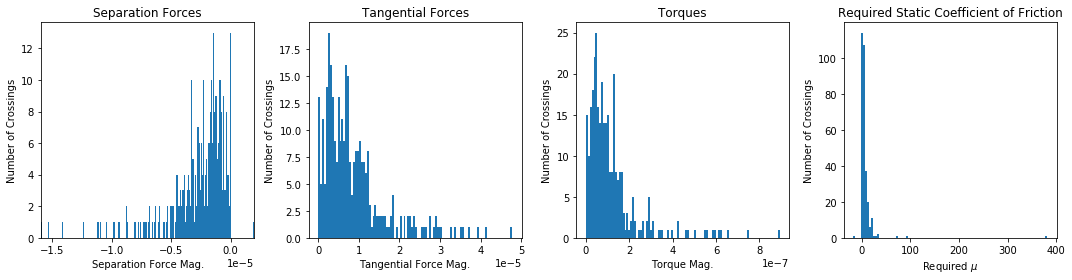

In [40]:
structure_view_6 = get_structure_analysis_view(curved_linkage)
structure_view_6.show()

In [41]:
optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, rw, sw, inner_gradTol = 1e-6)

In [42]:
optimizer, contact_opt_iterateData = contact_optimization(optimizer, curved_linkage, curved_linkage_view, minRestLen=-1, contact_weight = 5e6, normalWeight = 10, torqueWeight = 0, maxIter=2000, normalActivationThreshold=-1e-6)

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


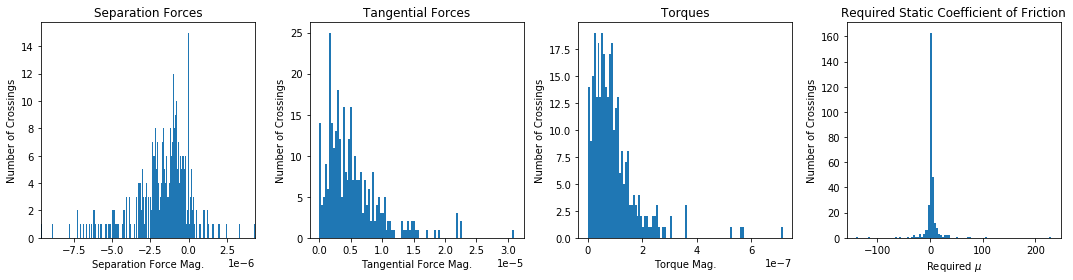

In [43]:
structure_view_7 = get_structure_analysis_view(curved_linkage)
structure_view_7.show()

In [44]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [298 297 289 293 306 307  70 281 139 137 313 124 120 183 184 101 100 204
  24 205 219 224  76  60 243 249 253 255  31 280 217 314]
0	0.000552554	0.451423	0.451423	0.5	1
1	0.000283585	2.44117	2.44117	1	1
2	0.000245842	0.337764	0.337764	1	1
3	0.000220582	0.171845	0.171845	1	1
4	0.000200859	0.0901559	0.0901559	1	1
5	0.000182176	0.0645507	0.0645507	1	1
6	0.000163174	0.0488154	0.0488154	1	1
7	0.000144101	0.036213	0.036213	1	1
8	0.000125404	0.0263809	0.0263809	1	1
9	0.000107284	0.0189633	0.0189633	1	1
10	9.01073e-05	0.0133755	0.0133755	0.5	0
11	5.88535e-05	0.0338914	0.0338914	1	1
12	5.13926e-05	0.00639488	0.00639488	1	1
13	4.56768e-05	0.00413392	0.00413392	1	1
14	4.08845e-05	0.00271781	0.00271781	1	0
15	3.14905e-05	0.0336046	0.0336046	1	1
16	2.89484e-05	0.000811686	0.000811686	1	1
17	2.87015e-05	0.000297855	0.000297855	0.5	0
18	2.82671e-05	0.0103081	0.0103081	1	1
19	2.8154e-05	0.00013889	0.00013889	1	0
20	2.79319e-05	0.0022423	0.0022423	1	0
21	2.79251e-05	0.0076969	0.0076

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


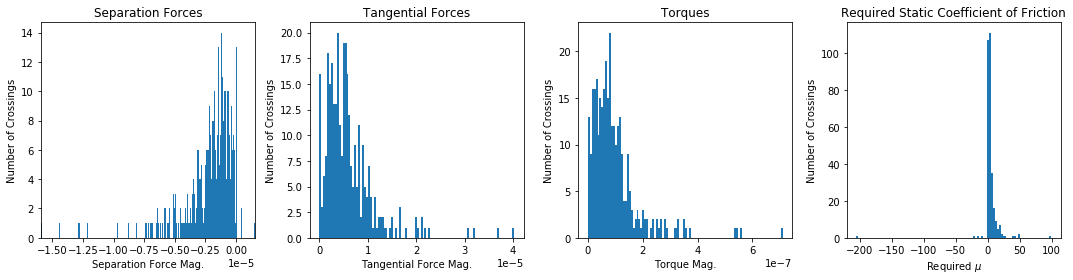

In [45]:
structure_view_8 = get_structure_analysis_view(curved_linkage)
structure_view_8.show()

In [46]:
cfm = structural_analysis.weavingCrossingForceMagnitudes(curved_linkage, True)
if np.sum(cfm[:, 0]>0) > 0:
    print("Flipping crossing: ", np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):])
    for i in np.argsort(cfm[:, 0] > 0)[-1 * np.sum(cfm[:, 0] > 0):]:
        curved_linkage.joint(i).type = get_opposite_joint_type(curved_linkage.joint(i).type)
    elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS)
    curved_linkage_view.update()

Flipping crossing:  [141 310  36 215]
0	6.23313e-05	0.0466393	0.0466393	0.0625	1
1	6.06381e-05	0.0695374	0.0695374	1	1
2	3.72884e-05	0.0196513	0.0196513	1	1
3	3.25718e-05	0.00397266	0.00397266	1	0
4	2.91925e-05	0.0133829	0.0133829	1	1
5	2.83546e-05	0.000542241	0.000542241	1	0
6	2.80051e-05	0.0024786	0.0024786	0.03125	0
7	2.79989e-05	0.00241244	0.00241244	0.5	0
8	2.79938e-05	0.0151671	0.0151671	1	1
9	2.79628e-05	0.000105033	0.000105033	1	0
10	2.79319e-05	0.00230087	0.00230087	0.125	0
11	2.79284e-05	0.00173588	0.00173588	1	0
12	2.79235e-05	0.000874706	0.000874706	1	0
13	2.79218e-05	0.0021824	0.0021824	0.03125	0
14	2.79216e-05	0.00212764	0.00212764	1	0
15	2.79201e-05	0.000306644	0.000306644	0.5	0
16	2.79198e-05	0.000734192	0.000734192	1	0
17	2.79195e-05	0.000292854	0.000292854	1	0
18	2.79195e-05	0.000108264	0.000108264	1	0
19	2.79194e-05	1.75315e-05	1.75315e-05	0.125	0
20	2.79194e-05	1.88614e-05	1.88614e-05	1	0
21	2.79194e-05	5.32613e-06	5.32613e-06	1	0
22	2.79194e-05	1.71195e-05	1.71195e

Coefficient of Friction Percentiles 50, 75, 90:  nan nan nan


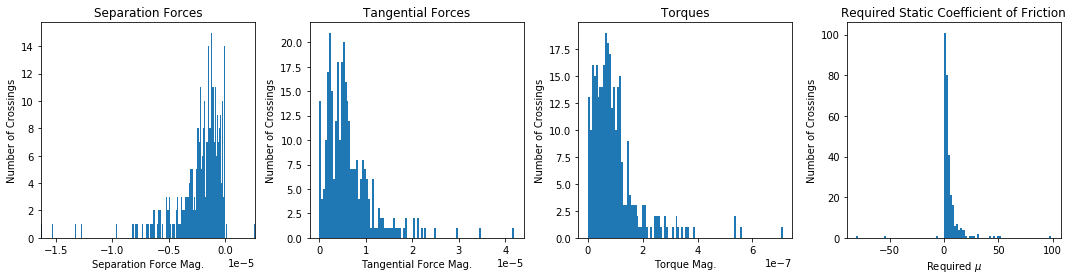

In [47]:
structure_view_9 = get_structure_analysis_view(curved_linkage)
structure_view_9.show()

In [ ]:
# DEBUG = True
# name = 'bunny'
# data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
# optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)

In [ ]:
# DEBUG = True
# name = 'bunny'
# data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
# optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)
# print('Computing Visualization Data ', name)
# np.save(optimization_data_filename, [iterateData, opt_iterateData])


In [ ]:
# drw = 0.1
# dsw = 0.1

# DEBUG = True
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)

# vs = Visualization_Setting()

# def get_optimization_diagram_worker():
#     name = 'bunny'
#     data_filename = '{}/{}_{}_data.npy'.format('results/{}'.format(name), name, 'full_data' if not DEBUG else 'finite_sample')
#     optimization_data_filename = '{}/{}_optimization.npy'.format('results/{}'.format(name), name)
#     print('Computing Visualization Data ', name)
#     np.save(optimization_data_filename, [iterateData, opt_iterateData])
    
#     dps_total_absolute_curvature, dps_total_ribbon_length, dps_distance_to_surface, dps_distance_to_joint, dps_eqm_dofs, dps_elastic_energy = compute_visualization_data_from_raw_data(iterateData, io, DEBUG, is_bunny = True)

#     opt_total_absolute_curvature, opt_total_ribbon_length, opt_distance_to_surface, opt_distance_to_joint, opt_eqm_dofs, opt_elastic_energy = compute_visualization_data_from_raw_data(opt_iterateData, io, DEBUG, is_bunny = True)

#     combined_energy = np.array(dps_elastic_energy + opt_elastic_energy)
#     combined_rest_length = np.array(dps_total_ribbon_length + opt_total_ribbon_length)
#     combined_total_absolute_curvature = np.array(dps_total_absolute_curvature + opt_total_absolute_curvature)
#     combined_distance_to_surface = np.array(dps_distance_to_surface + opt_distance_to_surface)
#     combined_dis_to_target_joint = np.array(dps_distance_to_joint + opt_distance_to_joint)

#     curr_data = np.array([combined_energy, combined_rest_length, combined_total_absolute_curvature, combined_distance_to_surface, combined_dis_to_target_joint, dps_eqm_dofs, opt_eqm_dofs])
#     np.save(data_filename, curr_data)

#     dps_objective_elastic, dps_objective_smooth, dps_objective_length, dps_total_objective = get_objective_components_stage1(iterateData)
#     opt_objective_elastic, opt_objective_target, opt_objective_length, opt_objective_smooth, opt_total_objective = get_objective_components_stage2(opt_iterateData)
    
#     combined_weighted_smoothing = np.concatenate((dps_objective_smooth, opt_objective_smooth), axis = None)

#     # Objective plots
#     plot_objective(vs, iterateData, dps_total_objective, '{}/{}_stage_1_objective.png'.format('results/{}'.format(name), name), vs.stage_1_label)
#     plot_objective(vs, opt_iterateData, opt_total_objective, '{}/{}_stage_2_objective.png'.format('results/{}'.format(name), name), vs.stage_2_label)
    
#     def plot_stage_1_components():
#         fig, host = plt.subplots()
#         fig.subplots_adjust(right=0.75)
#         par1 = host.twinx()
#         par2 = host.twinx()
#         par3 = host.twinx()
#         par4 = host.twinx()

#         par2.spines["left"].set_position(("axes", -0.12))
#         make_patch_spines_invisible(par2)

#         par2.spines["left"].set_visible(True)
#         par2.yaxis.set_label_position('left')
#         par2.yaxis.set_ticks_position('left')

#         par3.spines["left"].set_position(("axes", -0.24))

#         make_patch_spines_invisible(par3)

#         par3.spines["left"].set_visible(True)
#         par3.yaxis.set_label_position('left')
#         par3.yaxis.set_ticks_position('left')

#         n_iter = len(dps_elastic_energy)

#         p1, = host.plot(range(n_iter), dps_elastic_energy, linewidth = 3, color = vs.elastic_color, label=vs.elastic_label)
#         p2, = par1.plot(range(n_iter), dps_total_ribbon_length, linewidth = 3, color = vs.rest_length_color, label=vs.rest_length_label)
#         # print(len(dps_objective_smooth), n_iter)
#         p3, = par2.plot(range(n_iter), np.array(dps_objective_smooth)[[0, int(len(iterateData)/4), int(3 * len(iterateData)/4), int(len(iterateData)-1)]], linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label) if DEBUG else par2.plot(range(n_iter), np.array(dps_objective_smooth), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label)
#         p4, = par3.plot(range(n_iter), dps_total_absolute_curvature, linewidth = 3, color = vs.curvature_color, label=vs.curvature_label)
#         p5, = par4.plot(range(n_iter), dps_distance_to_surface, linewidth = 3, color = vs.target_color, label=vs.target_label)

#         set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5, combined_energy, combined_rest_length, combined_weighted_smoothing, combined_total_absolute_curvature, combined_distance_to_surface, vs)

#         lines = [p1, p2, p3, p4, p5]

#         par1.yaxis.set_visible(False)
#         par2.yaxis.set_visible(True)
#         par3.yaxis.set_visible(True)
#         par4.yaxis.set_visible(False)

#         fig.set_size_inches(vs.figure_size)
#         fig.savefig('{}/{}_stage_1_components.png'.format('results/{}'.format(name), name), bbox_inches='tight', dpi=200)
#         plt.close()
#     plot_stage_1_components()

#     def plot_stage_2_components():
#         fig, host = plt.subplots()
#         fig.subplots_adjust(right=0.75)

#         par1 = host.twinx()
#         par2 = host.twinx()
#         par3 = host.twinx()
#         par4 = host.twinx()

#         par2.spines["right"].set_position(("axes", 1.12))

#         make_patch_spines_invisible(par2)
#         par2.spines["right"].set_visible(False)


#         par3.spines["right"].set_position(("axes", 1.24))
#         make_patch_spines_invisible(par3)
#         par3.spines["right"].set_visible(False)

#         par4.spines["right"].set_position(("axes", 1.12))
#         make_patch_spines_invisible(par4)
#         par4.spines["right"].set_visible(True)


#         x_range = [-1] + list(range(len(opt_elastic_energy)))

#         # Samara temp view slice
#         # opt_objective_smooth = opt_objective_smooth[[0, int(len(opt_iterateData)/4), int(3 * len(opt_iterateData)/4), int(len(opt_iterateData)-1)]]
#         p1, = host.plot(x_range, [dps_elastic_energy[-1]] + list(opt_elastic_energy), linewidth = 3, color = vs.elastic_color, label=vs.elastic_label)
#         p2, = par1.plot(x_range, [dps_total_ribbon_length[-1]] + list(opt_total_ribbon_length), linewidth = 3, color = vs.rest_length_color, label=vs.rest_length_label)
#         p3, = par2.plot(x_range, [dps_objective_smooth[-1]] + list(np.array(opt_objective_smooth)[[0, int(len(opt_iterateData)/4), int(3 * len(opt_iterateData)/4), int(len(opt_iterateData)-1)]]), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label) if DEBUG else par2.plot(x_range, [dps_objective_smooth[-1]] + list(np.array(opt_objective_smooth)), linewidth = 3, color = vs.smoothness_color, label=vs.smoothness_label)
#         p4, = par3.plot(x_range, [dps_total_absolute_curvature[-1]] + list(opt_total_absolute_curvature), linewidth = 3, color = vs.curvature_color, label=vs.curvature_label)
#         p5, = par4.plot(x_range, [dps_distance_to_surface[-1]] + list(opt_distance_to_surface), linewidth = 3, color = vs.target_color, label=vs.target_label)

#         set_figure_label_and_limit(host, par1, par2, par3, par4, p1, p2, p3, p4, p5, combined_energy, combined_rest_length, combined_weighted_smoothing, combined_total_absolute_curvature, combined_distance_to_surface, vs)

#         lines = [p1, p2, p3, p4, p5]

#         host.yaxis.set_visible(False)
#         par1.yaxis.set_visible(True)
#         par2.yaxis.set_visible(False)
#         par3.yaxis.set_visible(False)
#         par4.yaxis.set_visible(True)
#         # plt.axvline(x=opt_iteration_count, color=cmap(8), linestyle='--')
#         leg = host.legend(lines, [l.get_label() for l in lines], loc="upper right", facecolor='white', framealpha=1, fancybox=True, prop={'size': 15})

#         bb = leg.get_bbox_to_anchor().inverse_transformed(host.transAxes)

#         # Change to location of the legend. 
#         yOffset = -0.2
#         bb.y0 += yOffset
#         leg.set_bbox_to_anchor(bb, transform = host.transAxes)
#         fig.set_size_inches(vs.figure_size)
#         fig.savefig('{}/{}_stage_2_components.png'.format('results/{}'.format(name), name), bbox_inches='tight', dpi=200)
#         plt.close()


#     plot_stage_2_components()
    
# get_optimization_diagram_worker()